In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
import random
from sklearn.linear_model import LinearRegression
%matplotlib inline
from datetime import datetime

In [2]:
##Check why vegetation is null
##Clean up the last codes to make this look better
def county(number):
        if number == 333:
            return 'wise'
        elif number == 988:
            return 'denton'
        elif number == 951:
            return 'collin'
        elif number == 1308:
            return 'parker'
        elif number == 2049:
            return 'tarrant'
        elif number == 978:
            return 'dallas'
        elif number == 2516:
            return 'rockwall'
        elif number == 1833:
            return 'kaufman'
        elif number == 1827:
            return 'johnson'
        elif number == 498:
            return 'ellis'
        else:
            return 'none'

##Fill the first list of values with "['']" variables
##Fill the null values with "['None']" for columns with list variables in string form
def fill_null_values1(df, col):
    df.loc[df[col].isnull(), col] = "['none']"
    return df

##Transform these lists of variables into columns:
##If next time we end up with a extra column, we can add that extra column to sql
def categorical_features_generator1(df, col):
    list_feature = list()
    list_temp = df[col].unique()
    for feature in list_temp:
        list1 = feature[1:-1].replace("'", "").replace(" ", "").split(",")
        for value in list1:
            value = value.lower()
            if value not in list_feature:
                list_feature.append(value)
    return list_feature

##Transform the rows values into type list to fill in 1 and 0's for these new features
def row_categorical_extract1(variable, feature):
    list1 = variable[1:-1].replace("'", "").replace(" ", "").split(",")
    list1 = [x.lower() for x in list1]
    if feature in list1:
        return 1
    else:
        return 0

##After getting the list feature from that function,
##We create a new dataframe with all of those features, include the zpid
def create_categorical_columns1(df, col, list_feature): 
    ##We split the column name from resoFacts to look cleaner
    name = col.split(".")[1]
    columns = list()
    for feature in list_feature:
        df[name + "_" + feature] = df.apply(lambda x: row_categorical_extract1(x[col], feature), axis = 1)
        columns.append(name + "_" + feature)
    return df, columns, name

##Create a subdataframe with all the values generated above with zpid
def sub_dataframe1(df, columns):
    new_columns = ['zpid'] + columns
    return df[new_columns]

##Haversine: Calculate distance between two places based on their longitudes and latitudes
def haversine(lat1, lon1, lat2, lon2):
     
    # distance between latitudes and longitudes
    dLat = (lat2 - lat1) * math.pi / 180.0
    dLon = (lon2 - lon1) * math.pi / 180.0
 
    # convert to radians
    lat1 = (lat1) * math.pi / 180.0
    lat2 = (lat2) * math.pi / 180.0
 
    # apply formulae
    a = (pow(math.sin(dLat / 2), 2) +
         pow(math.sin(dLon / 2), 2) *
             math.cos(lat1) * math.cos(lat2))
    rad = 6371
    c = 2 * math.asin(math.sqrt(a))
    return rad * c  * 0.621371 ##Convert into miles

def isd_house(df_temp, long1, lat1):
    distance_list = list()
    for i in range(len(df_temp)):
        long2 = df_temp.iloc[i]['longitude']
        lat2 = df_temp.iloc[i]['latitude']
        distance = haversine(lat1, long1, lat2, long2)
        distance_list.append(distance)
    idx = distance_list.index(min(distance_list))
    isd = df_temp.iloc[idx]['resoFacts.elementarySchoolDistrict']
    return isd

##Fill Null with None for these features:
##resoFacts.structureType, resoFacts.architecturalStyle, resoFacts.fencing, resoFacts.roofType
##Features that have variables: "Compositon,tile"
def fill_null_values2(df, col):
    df.loc[df[col].isnull(), col] = 'none'
    return df

def categorical_features_generator2(df, col):
    list_feature = list()
    list_temp = df[col].unique()
    for feature in list_temp:
        list1 = feature.split(",")
        for value in list1:
            value = value.lower()
            if value not in list_feature:
                list_feature.append(value)
    return list_feature

def row_categorical_extract2(variable, feature):
    list1 = variable.split(",")
    list1 = [x.lower() for x in list1]
    if feature in list1:
        return 1
    else:
        return 0

def create_categorical_columns2(df, col, list_feature): 
    ##We split the column name from resoFacts to look cleaner
    name = col.split(".")[1]
    columns = list()
    for feature in list_feature:
        df[name + "_" + feature] = df.apply(lambda x: row_categorical_extract2(x[col], feature), axis = 1)
        columns.append(name + "_" + feature)
    return df, columns, name


In [3]:
class main_df:
    def __init__(self, path_prop, path_API, path_crime, columns):
        ##Read in the cleaned dataset pulled from API
        self.__df_API = pd.read_csv(path_API, low_memory = False)
        
        ##Read in the raw houses properties dataframe
        self.__df = pd.read_csv(path_prop, low_memory = False)[columns]
        self.__df_crime = pd.read_csv(path_crime)
        self.__df_categorical = dict()
    
        ##Deal with basic issue
        ##drop rows with null zpid
        self.__df.dropna(subset = ['zpid', 'longitude', 'latitude'], how = 'any', inplace = True)
        self.__df.drop(labels = ['resoFacts.yearBuilt'], axis = 1, inplace = True)
        
    def county_name(self):
        self.__df['county'] = self.__df['countyId'].apply(county)
    
    def generate_dict1(self, string_brackets_columns):
        for col in string_brackets_columns:
            self.__df = fill_null_values1(self.__df, col)
            list_feature = categorical_features_generator1(self.__df, col)
            self.__df, columns, name = create_categorical_columns1(self.__df, col, list_feature)
            df_sub = sub_dataframe1(self.__df, columns)
            ##Drop all of these columns, including the original names after the extraction
            self.__df.drop(labels = columns + [col], axis = 1, inplace = True)
            ##Make sure to save dict later
            ##Do dictionary for easier access later on
            self.__df_categorical[col] = df_sub
    
    ##Check if there are any null values in the dataframe
    def all_null_vals(self):
        columns = self.__df.columns.tolist()
        for col in columns:
            print("Null in "+ col + ": {}".format(self.__df[col].isnull().sum()))
    
    ##fill null price, living area, living are per square feet of the data frame
    def fill_null_price_area(self):
        ##look for zpid that does not have a price tag with it
        zpid_list = self.__df.loc[(self.__df['resoFacts.pricePerSquareFoot'].isnull()) | (self.__df['price'].isnull()) | 
                            (self.__df['livingAreaValue'].isnull()) | (self.__df['resoFacts.pricePerSquareFoot'] == 0) | 
                            (self.__df['price'] == 0) | (self.__df['livingAreaValue'] == 0)]['zpid'].tolist()

        #print(zpid_list)
        ##fill in the price columns with the house api
        for zpid in zpid_list:
            #print(zpid)
            price_api = self.__df_API.loc[self.__df_API['zpid'] == zpid]['price'].tolist()[0]
            livingArea_api = self.__df_API.loc[self.__df_API['zpid'] == zpid]['livingArea'].tolist()[0]
            if (price_api != 0) and (not pd.isnull(price_api)) and (livingArea_api != 0) and (not pd.isnull(livingArea_api)):
                self.__df.loc[self.__df['zpid'] == zpid, 'price'] = price_api
                self.__df.loc[self.__df['zpid'] == zpid, 'livingAreaValue'] = livingArea_api
            self.__df.loc[self.__df['zpid'] == zpid, 'resoFacts.pricePerSquareFoot'] = np.round(price_api/livingArea_api)
    
    ##Get the lot area from API
    ##lotArea is actually a not useful value as I check it multiple times.
    def lot_Area_join(self):
        self.__df = self.__df.merge(self.__df_API[['zpid', 'lotArea']], how = 'inner', on = 'zpid')
    
    ##We want houses that are less than $2 million
    def affordable_houses(self, price_cap = 2000000):
        self.__df = self.__df.loc[(self.__df['price'] <= 2000000)]

    ##resoFacts.structureType, resoFacts.architecturalStyle, 
    ##resoFacts.fencing, resoFacts.roofType have string contains multiple features
    ##Same as generatedict1 but a different way of doing it
    def generate_dict2(self, string_comma_columns):
        for col in string_comma_columns:
            self.__df = fill_null_values2(self.__df, col)
            list_feature = categorical_features_generator2(self.__df, col)
            self.__df, columns, name = create_categorical_columns2(self.__df, col, list_feature)
            df_sub = sub_dataframe1(self.__df, columns)
            ##Drop all of these columns, including the original names after the extraction
            self.__df.drop(labels = columns + [col], axis = 1, inplace = True)
            ##Make sure to save dict later
            ##Do dictionary for easier access later on
            self.__df_categorical[col] = df_sub
    
    ##Choose houses based on property sub types
    ##Choouse houses that have propertysubtype_SingleFamilyResidence = 1
    def pick_property_sub_type(self):
        df_property_type = self.__df_categorical['resoFacts.propertySubType'].copy()
        zpid_list = df_property_type.loc[df_property_type['propertySubType_singlefamilyresidence'] == 1]['zpid'].tolist()
        self.__df = self.__df.loc[self.__df['zpid'].isin(zpid_list)]
        
    def fix_structure_type(self):
        ##Drop houses that have a structure called apartment or underground in the main dataframe
        df_structure = self.__df_categorical['resoFacts.structureType'].copy()
        all_cols = df_structure.columns.tolist()
        zpid_list = list()
        if 'structureType_apartment' in all_cols:
            zpid_list += (df_structure.loc[df_structure['structureType_apartment'] == 1]['zpid'].tolist())
        if 'structureType_underground' in all_cols:
            zpid_list += (df_structure.loc[df_structure['structureType_underground'] == 1]['zpid'].tolist())
        ##Remove duplicates in a list
        if (len(zpid_list) != 0) and ('structureType_apartment' in all_cols) and ('structureType_underground' in all_cols):
            zpid_list = [*set(zpid_list)]
            self.__df = self.__df.loc[~(self.__df['zpid'].isin(zpid_list))]
            ##Remove rows where these values equal to 1, then remove these two columns
            df_structure = df_structure.loc[(df_structure['structureType_apartment'] != 1) & 
                                            (df_structure['structureType_underground'] != 1)]
            df_structure.drop(labels = ['structureType_apartment', 'structureType_underground'], axis = 1, inplace = True)
            self.__df_categorical['resoFacts.structureType'] = df_structure
    
    ##Monthly Hoa:
    def fill_HOA_fees(self):
        ##Fill houses with no associations with hoaFee = 0 and resoFacts.hoaFee = '$0 other'
        ##There are houses that have associations but don't show actual monthlyFees
        self.__df.loc[(self.__df['resoFacts.hoaFee'].isnull()) & (self.__df['monthlyHoaFee'].isnull()) & 
                      (self.__df['resoFacts.hasAssociation'] == False), 'monthlyHoaFee'] = 0
        self.__df.loc[(self.__df['resoFacts.hoaFee'].isnull()) & (self.__df['monthlyHoaFee'] == 0) &
                      (self.__df['resoFacts.hasAssociation'] == False), 'resoFacts.hoaFee'] = '$0 other'
        
        ##Drop houses with a few null values in monthly HOA since the set of null values is too small to fix
        ##Second, each house may have a different association from one another even if they have the same zipcode
        ##Drop 'resoFacts.associationFeeIncludes', does not include any importantFeatures
        self.__df.dropna(subset = ['monthlyHoaFee'], inplace = True)
        self.__df.drop(labels = ['resoFacts.associationFeeIncludes'], axis = 1, inplace = True)
    
    ##Fill null isd for houses that don't have isd based on their cities and zipcodes
    def fill_null_isd(self):
        df_isd_null = self.__df.loc[self.__df['resoFacts.elementarySchoolDistrict'].isnull()]
        for i in range(len(df_isd_null)):
            city = df_isd_null.iloc[i]['city']
            zipcode = df_isd_null.iloc[i]['zipcode']
            long1 = df_isd_null.iloc[i]['longitude']
            lat1 = df_isd_null.iloc[i]['latitude']
            streetAddress = df_isd_null.iloc[i]['streetAddress']
            df_temp = self.__df.loc[(self.__df['zipcode'] == zipcode) & (self.__df['city'] == city) 
                                    & ~(self.__df['resoFacts.elementarySchoolDistrict'].isnull())]
            if len(df_temp) != 0:
                isd = isd_house(df_temp, long1, lat1)
                self.__df.loc[self.__df['streetAddress'] == streetAddress, 'resoFacts.elementarySchoolDistrict'] = isd
        
        ##Drop rows with null isd
        self.__df.dropna(subset = ['resoFacts.elementarySchoolDistrict'], how = 'any', inplace = True)
        
        ##Create a column school district and drops other district column
        self.__df['SchoolDistrict'] = self.__df['resoFacts.elementarySchoolDistrict']
        self.__df.drop(labels = ['resoFacts.elementarySchoolDistrict', 'resoFacts.middleOrJuniorSchoolDistrict', 
                                 'resoFacts.highSchoolDistrict'], axis = 1, inplace = True)
    
    ##Fill null SeniorCommunity with False since the one that is not null is always true
    def fill_null_SeniorCommunity(self):
        self.__df.loc[(self.__df['resoFacts.isSeniorCommunity'].isnull()), 'resoFacts.isSeniorCommunity'] = False
    
    ##Every house system should have heating and cooling
    ##If the house doesn't have a cooling or it's null, then very likely it's not a house
    ##Drop house that has no cooling or heating since most likely, they are just lands
    def fix_null_cool_heat(self):
        ##Only choose houses when this is true
        self.__df = self.__df.loc[(self.__df['resoFacts.hasCooling'] == True) & 
                                  (self.__df['resoFacts.hasHeating'] == True)] 
        
        ##Fix the dataframe in resoFacts.cooling and resoFacts.heating
        ##If cooling and heating is None, switch to cooling_Other
        ##Other means that the other types of features are not listed in the original features
        ##Drop the None feature
        df_cooling = self.__df_categorical['resoFacts.cooling'].copy()
        df_heating = self.__df_categorical['resoFacts.heating'].copy()
        df_cooling.loc[df_cooling['cooling_none'] == 1, 'cooling_other'] = 1
        df_heating.loc[df_heating['heating_none'] == 1, 'heating_other'] = 1
        df_cooling.drop(labels = ['cooling_none'], axis = 1, inplace = True)
        df_heating.drop(labels = ['heating_none'], axis = 1, inplace = True)
        self.__df_categorical['resoFacts.cooling'] = df_cooling
        self.__df_categorical['resoFacts.heating'] = df_heating
    
    def fix_pool_features(self):
        #For null values, if we check the pool features dataframe and 
        #there is a feature that is there except Poolfeatures_None, then we are likely to have a Private Pool
        zpid_list1 = self.__df.loc[self.__df['resoFacts.hasPrivatePool'].isnull()]['zpid'].tolist()
        df_pool = self.__df_categorical['resoFacts.poolFeatures'].copy()
        for zpid in zpid_list1:
            None_zpid = df_pool.loc[df_pool['zpid'] == zpid]['poolFeatures_none'].iloc[0]
            if None_zpid == 1:
                self.__df.loc[self.__df['zpid'] == zpid, 'resoFacts.hasPrivatePool'] = False
            elif None_zpid == 0:
                self.__df.loc[self.__df['zpid'] == zpid, 'resoFacts.hasPrivatePool'] = True
        
        ##Next we need to ensure that every house that has a private pool has the feature private equals to 1
        zpid_list2 = self.__df.loc[self.__df['resoFacts.hasPrivatePool'] == True]['zpid'].tolist()
        df_pool.loc[(df_pool['zpid'].isin(zpid_list2)), 'poolFeatures_private'] = 1
        ##Remove the feature poolFeatures_pool and tick 1 for poolFeatures_Other
        ##If the dataframe has poolFeatures_Other/SeeRemarks just tick 1 for poolFeatures_Other and drop this column
        if 'poolFeatures_pool' in df_pool.columns.tolist():
            df_pool.loc[df_pool['poolFeatures_pool'] == 1, 'poolFeatures_other'] = 1
            df_pool.drop(labels = ['poolFeatures_pool'], axis = 1, inplace = True)
        if 'poolFeatures_other/seeremarks' in df_pool.columns.tolist():
            df_pool.loc[df_pool['poolFeatures_other/seeremarks'] == 1, 'poolFeatures_other'] = 1
            df_pool.drop(labels = ['poolFeatures_other/seeremarks'], axis = 1, inplace = True)
        self.__df_categorical['resoFacts.poolFeatures'] = df_pool
    
    ##Fix fireplace separately since it also involves columns from another dataframe
    def fix_fireplace(self):
        ##'resoFacts.hasFireplace', 'resoFacts.fireplaces' fix these variables so they make sense
        self.__df.loc[(self.__df['resoFacts.hasFireplace'].isnull()) & (self.__df['resoFacts.fireplaces'].isnull()), 
                      'resoFacts.fireplaces'] = 0
        self.__df.loc[(self.__df['resoFacts.hasFireplace'].isnull()) & (self.__df['resoFacts.fireplaces'] == 0), 
                      'resoFacts.hasFireplace'] = False
        self.__df.loc[(self.__df['resoFacts.hasFireplace'].isnull()) & (self.__df['resoFacts.fireplaces'] != 0), 
                      'resoFacts.hasFireplace'] = True
        self.__df.loc[(self.__df['resoFacts.hasFireplace'] == False) & (self.__df['resoFacts.fireplaces'].isnull()), 
                      'resoFacts.fireplaces'] = 0
        self.__df.loc[(self.__df['resoFacts.hasFireplace'] == True) & (self.__df['resoFacts.fireplaces'].isnull()), 
                      'resoFacts.fireplaces'] = 1
        
        ##Then for places with fireplaces, make sure that they don't check None
        df_fireplace = self.__df_categorical['resoFacts.fireplaceFeatures'].copy()
        zpid_list = self.__df[self.__df['resoFacts.hasFireplace'] == True]['zpid'].tolist()
        for zpid in zpid_list:
            None_t = df_fireplace.loc[df_fireplace['zpid'] == zpid]['fireplaceFeatures_none'].iloc[0]
            if None_t == 1:
                df_fireplace.loc[df_fireplace['zpid'] == zpid, 'fireplaceFeatures_other'] = 1
                df_fireplace.loc[df_fireplace['zpid'] == zpid, 'fireplaceFeatures_none'] = 0
        self.__df_categorical['resoFacts.fireplaceFeatures'] = df_fireplace
    
    ##These are the features should not have 'none' since they are necessary for a home to exist
    def fix_Other_features(self, Other_features):
        ##Every feature has None and Other, except waterSource
        ##Ok so when i run this code once it actually change the dataset within the dictionary
        ##use .copy() just in case
        for feature in Other_features:
            df_cat = self.__df_categorical[feature].copy()
            all_cols = df_cat.columns.tolist()[1:]
            name = all_cols[0].split('_')[0]
            spec_list = list()
            for col in all_cols:
                spec = col.split('_')[1]
                spec_list.append(spec)
            #print(spec_list)
            if 'none' in spec_list:
                if 'other' in spec_list:
                    df_cat.loc[df_cat[name + '_' + 'none'] == 1, name + '_' + 'other'] = 1
                elif 'other' not in spec_list:
                    df_cat[name + '_' + 'other'] = df_cat[name + '_' + 'none']
                df_cat.drop(labels = [name + '_' + 'none'], axis = 1, inplace = True)
            self.__df_categorical[feature] = df_cat
    
    ##Feature should only have None = 0 if other columns = 1,
    ##If there are features = 1 and None is one of them, None should be 0.
    ##We don't drop None columns with this function
    def fix_None_features(self, None_features):
        for feature in None_features:
            df_cat = self.__df_categorical[feature].copy()
            all_cols = df_cat.columns.tolist()[1:]
            name = all_cols[0].split('_')[0]
            spec_list = list()
            for col in all_cols:
                spec = col.split('_')[1]
                spec_list.append(spec)
            if 'none' in spec_list:
                ##The sum of the columns are each row > 1 and None is ticked, change it to 0
                df_cat.loc[(df_cat.iloc[:, 1:].sum(axis = 1) != 1) & 
                           (df_cat[name + '_' + 'none'] == 1), name + '_' + 'none'] = 0
            self.__df_categorical[feature] = df_cat
    
    ##So Attached Garage is the Gargage that is attached to the house.
    ##If it is null, it's highly false. Same for carport
    def fix_Garage(self):
        self.__df[['resoFacts.hasAttachedGarage', 'resoFacts.hasCarport']] = self.__df[['resoFacts.hasAttachedGarage', 'resoFacts.hasCarport']].fillna(False)
        self.__df.loc[(self.__df['resoFacts.hasGarage'] == False) & (self.__df['resoFacts.hasAttachedGarage'] == True), 
                      'resoFacts.hasGarage'] = True
        self.__df.loc[(self.__df['resoFacts.garageSpaces'].isnull()) & (self.__df['resoFacts.hasGarage'] == False),
                      'resoFacts.garageSpaces'] = 0
        self.__df.loc[(self.__df['resoFacts.carportSpaces'].isnull()) & (self.__df['resoFacts.hasCarport'] == False),
                      'resoFacts.carportSpaces'] = 0
        self.__df.drop(self.__df[(self.__df['resoFacts.garageSpaces'].isnull()) | 
                                 (self.__df['resoFacts.carportSpaces'].isnull())|
                                 (self.__df['resoFacts.coveredSpaces'].isnull())].index, inplace = True)
    
    def fix_Construction(self):
        self.__df['resoFacts.isNewConstruction'].fillna(value = False, inplace = True)
    
    ##Drop houses with null mortgage rates
    ##2 houses right next each other can't have the same mortgage rates
    def fix_null_rates(self):
        self.__df.drop(self.__df[(self.__df['mortgageRates.fifteenYearFixedRate'].isnull()) |
                                 (self.__df['mortgageRates.thirtyYearFixedRate'].isnull()) |
                                 (self.__df['mortgageRates.arm5Rate'].isnull())].index, inplace = True)
        
    ##This function will drop unnecessary columns for the main dataframe
    def final_drop_columns(self, unnecessary_cols):
        self.__df.drop(labels = unnecessary_cols, axis = 1, inplace = True)
    
    ##Drop all rows that is still null, last step to clean the main df
    def final_drop_rows(self):
        self.__df.dropna(axis = 0, how = 'any', inplace = True)
    
    ##Join the main data frame with crime rate data
    ##Insert the column crimes per 1000 population to the main dataframe
    def join_crime_data(self, year):
        df_temp = self.__df_crime.copy()
        main_df = self.__df.copy()
        df_temp['Crime_per_1000'] = df_temp[year]
        df_temp['county'] = df_temp['County'].str.lower()
        self.__df = main_df.merge(df_temp[['county', 'Crime_per_1000']], how = 'left', on = 'county')
    
    ##Important: clean the df_test first before using this function, we use len(df_test to do the ratio)
    ##This function will only keep some columns for a given threshold (%)
    def important_features(self, selected_features, threshold_drop = 5):
        main_df = self.__df.copy()
        for feature in selected_features:
            df_cat = self.__df_categorical[feature].copy()
            cols = df_cat.columns.tolist()[1:]
            name = cols[0].split('_')[0]
            ##Do a join between the main dataframe and each categorical feature dataframe
            df_temp = main_df.merge(df_cat, how = 'inner', on = 'zpid')
            df_temp.drop_duplicates(subset = ['zpid'], keep = 'first', inplace = True)
            ##For the columns we want to keep 'None' and 'Other' if the dataframes have them
            for j in range(len(cols)):
                ft = cols[j].split('_')[1]
                if ('none' not in cols[j]) and ('other' not in cols[j]):
                    ##If the categorical features only = 1 for a few house, just place it under 'Other'
                    percent_data = (df_temp.loc[df_temp[cols[j]] == 1].shape[0] / df_temp.shape[0]) * 100
                    if (math.ceil(percent_data) < threshold_drop):
                        #This is when 'Other is a part of the columns'
                        df_cat.loc[df_cat[cols[j]] == 1, name + '_' + 'other'] = 1
                        df_cat.drop(labels = [cols[j]], axis = 1, inplace = True)
                elif cols[j] == name + '_' + 'other/seeremarks' or cols[j] == name + '_' + 'other/see remarks':
                    df_cat.loc[df_cat[cols[j]] == 1, name + '_' + 'other'] = 1
                    df_cat.drop(labels = [cols[j]], axis = 1, inplace = True)
                ##Create a case where Other is in a string like 'People(Other)'
                elif ('other' in ft) and len(ft) > 5:
                    percent_data = (df_temp.loc[df_temp[cols[j]] == 1].shape[0] / df_temp.shape[0]) * 100
                    if (math.ceil(percent_data) < threshold_drop):
                        #This is when 'Other is a part of the columns'
                        df_cat.loc[df_cat[cols[j]] == 1, name + '_' + 'other'] = 1
                        df_cat.drop(labels = [cols[j]], axis = 1, inplace = True)
                elif ('none' in ft) and len(ft) > 4:
                    percent_data = (df_temp.loc[df_temp[cols[j]] == 1].shape[0] / df_temp.shape[0]) * 100
                    if (math.ceil(percent_data) < threshold_drop):
                        #This is when 'Other is a part of the columns'
                        df_cat.loc[df_cat[cols[j]] == 1, name + '_' + 'other'] = 1
                        df_cat.drop(labels = [cols[j]], axis = 1, inplace = True)
                        
            self.__df_categorical[feature] = df_cat
    
    ##Save the main dataframe
    def save_main_df(self, path_save):
        self.__df.to_csv(path_save, index = False)
    
    def save_categories_df(self, path_save):
        for category, df in self.__df_categorical.items():
            feat = category.split('.')[1]
            name = 'houses' + '_' + feat + '.csv'
            df.to_csv(path_save + name, index = False)
            
    ##Return a dictionary of categorical dataframes
    def return_df_dict(self):
        return self.__df_categorical
    
    ##Return the API data frame
    def return_df_API(self):
        return self.__df_API
    
    ##Return the Crime dataframe
    def return_df_crime(self):
        return self.__df_crime
        
    ##Return the house with 100s features df
    def return_df_house_properties(self):
        return self.__df

In [4]:
cols = ['zpid', 'isListedByOwner', 'resoFacts.isSeniorCommunity', 'resoFacts.yearBuilt', 'resoFacts.hasAssociation', 
        'resoFacts.associationFeeIncludes', 'annualHomeownersInsurance', 'monthlyHoaFee', 'resoFacts.hoaFee', 
        'resoFacts.patioAndPorchFeatures', 'resoFacts.lotFeatures', 'resoFacts.sewer', 'resoFacts.waterSource', 'schools',
        'resoFacts.elementarySchool', 'resoFacts.elementarySchoolDistrict', 'resoFacts.middleOrJuniorSchool', 
        'resoFacts.highSchool', 'resoFacts.highSchoolDistrict', 'resoFacts.middleOrJuniorSchoolDistrict', 
        'resoFacts.pricePerSquareFoot', 'livingAreaValue', 'resoFacts.exteriorFeatures', 'resoFacts.hasPrivatePool',
        'resoFacts.poolFeatures', 'resoFacts.laundryFeatures',
        'resoFacts.propertySubType', 'resoFacts.interiorFeatures', 'solarPotential.sunScore', 'solarPotential.buildFactor',
        'solarPotential.climateFactor', 'solarPotential.electricityFactor', 'solarPotential.solarFactor', 
        'resoFacts.hasCooling', 'resoFacts.cooling', 'resoFacts.hasHeating', 'resoFacts.heating', 
        'resoFacts.structureType', 'resoFacts.windowFeatures', 'resoFacts.architecturalStyle', 'resoFacts.vegetation', 
        'resoFacts.fencing', 'resoFacts.greenEnergyEfficient', 'resoFacts.taxAnnualAmount', 'resoFacts.foundationDetails', 
        'resoFacts.canRaiseHorses', 'resoFacts.utilities', 'resoFacts.hasGarage', 'resoFacts.hasAttachedGarage', 
        'resoFacts.hasCarport', 'resoFacts.carportSpaces', 'resoFacts.parkingFeatures', 'resoFacts.garageSpaces', 
        'resoFacts.parking','resoFacts.hasSpa', 'resoFacts.hasView', 'resoFacts.homeType', 'resoFacts.rooms', 
        'resoFacts.coveredSpaces', 'resoFacts.constructionMaterials', 'resoFacts.appliances', 'resoFacts.flooring', 
        'resoFacts.basement', 'bedrooms', 'resoFacts.communityFeatures', 'resoFacts.bathrooms', 'resoFacts.bathroomsHalf', 
        'resoFacts.bathroomsFull', 'resoFacts.hasLandLease', 'resoFacts.hasFireplace', 'resoFacts.fireplaces', 
        'resoFacts.fireplaceFeatures', 'resoFacts.levels','resoFacts.securityFeatures', 'resoFacts.roofType', 
        'streetAddress', 'longitude', 'latitude', 'zipcode', 'countyId', 'city', 'resoFacts.buyerAgencyCompensation', 
        'resoFacts.buyerAgencyCompensationType', 'favoriteCount', 'resoFacts.isNewConstruction', 'mortgageRates.fifteenYearFixedRate', 
        'mortgageRates.thirtyYearFixedRate', 'mortgageRates.arm5Rate', 'propertyTaxRate', 'price']

In [5]:
Month = 'September'
Year = '2022'
path_prop = 'Raw_House_all_properties/' + Month + '_' + Year + '/houses_properties_data_' + Month + '.csv'
path_API = 'Clean_data_API_propertyExtendedSearch/' + Month + '_' + Year + '/cleaned_for_sales_houses_counties_' + Month + '.csv'
path_crime = 'Crime_rate/2021/Crime_rate_2021.csv'
class_df = main_df(path_prop, path_API, path_crime, columns = cols)

In [6]:
class_df.county_name()
class_df.fill_null_price_area()
class_df.affordable_houses()
class_df.fill_HOA_fees()
class_df.fill_null_isd()
class_df.fill_null_SeniorCommunity()

In [7]:
string_brackets_columns = ['resoFacts.patioAndPorchFeatures', 'resoFacts.waterSource', 'resoFacts.exteriorFeatures',
                           'resoFacts.interiorFeatures', 'resoFacts.communityFeatures', 'resoFacts.constructionMaterials',
                           'resoFacts.greenEnergyEfficient', 'resoFacts.foundationDetails', 
                           'resoFacts.utilities', 'resoFacts.appliances', 'resoFacts.flooring', 'resoFacts.parkingFeatures',
                           'resoFacts.lotFeatures', 'resoFacts.fireplaceFeatures', 'resoFacts.laundryFeatures', 
                           'resoFacts.propertySubType', 'resoFacts.securityFeatures', 
                           'resoFacts.cooling', 'resoFacts.windowFeatures', 'resoFacts.heating', 'resoFacts.sewer', 
                           'resoFacts.poolFeatures']

string_comma_columns = ['resoFacts.structureType', 'resoFacts.architecturalStyle', 
                        'resoFacts.fencing', 'resoFacts.roofType']

class_df.generate_dict1(string_brackets_columns)
class_df.generate_dict2(string_comma_columns)

In [8]:
class_df.pick_property_sub_type()
class_df.fix_structure_type()
class_df.fix_null_cool_heat()
class_df.fix_pool_features()
class_df.fix_fireplace()

In [9]:
##These columns should not have any None features since these features are neccessary for a house
##We don't need utilities since this feature is a combination of many other features
Other_cols = ['resoFacts.waterSource', 'resoFacts.exteriorFeatures', 'resoFacts.interiorFeatures', 
              'resoFacts.constructionMaterials', 'resoFacts.foundationDetails', 'resoFacts.appliances', 
              'resoFacts.flooring', 'resoFacts.windowFeatures', 'resoFacts.sewer', 'resoFacts.architecturalStyle', 
              'resoFacts.roofType']

None_cols = ['resoFacts.laundryFeatures', 'resoFacts.greenEnergyEfficient', 'resoFacts.lotFeatures', 
             'resoFacts.securityFeatures', 'resoFacts.communityFeatures', 
             'resoFacts.parkingFeatures', 'resoFacts.patioAndPorchFeatures', 'resoFacts.fencing']
class_df.fix_Other_features(Other_cols)
class_df.fix_None_features(None_cols)
class_df.fix_Garage()
class_df.fix_Construction()
class_df.fix_null_rates()

##Columns to drop for the main dataframe
Columns_to_drop = ['isListedByOwner', 'resoFacts.hoaFee', 'schools', 'resoFacts.elementarySchool', 
                   'resoFacts.middleOrJuniorSchool', 'resoFacts.highSchool', 
                   'resoFacts.pricePerSquareFoot', 'solarPotential.sunScore', 'solarPotential.buildFactor', 
                   'solarPotential.climateFactor', 'solarPotential.electricityFactor', 'solarPotential.solarFactor', 
                   'resoFacts.taxAnnualAmount', 'resoFacts.hasView', 'resoFacts.homeType', 'resoFacts.rooms', 
                   'resoFacts.basement', 'resoFacts.hasLandLease', 'resoFacts.buyerAgencyCompensation', 
                   'resoFacts.buyerAgencyCompensationType', 'favoriteCount', 'resoFacts.vegetation']

t = string_brackets_columns + string_comma_columns
Selected_features = list(set(t) - set(['resoFacts.utilities', 'resoFacts.propertySubType']))
class_df.final_drop_columns(Columns_to_drop)
class_df.final_drop_rows()
class_df.important_features(Selected_features, threshold_drop = 5)
class_df.join_crime_data(year = '2021')

##Save the cleaned dataframe and house categorical dataframe
path_main_df = 'Clean_data_House_properties/' + Month + '_' + Year + '/houses_properties_' + Month + '.csv'
path_category = 'Houses_categorical_property/' + Month + '_' + Year + '/'
class_df.save_main_df(path_main_df)
class_df.save_categories_df(path_category)

In [10]:
##Year Built doesn't matter since a house can always be remodeled
class_df.all_null_vals()

Null in zpid: 0
Null in resoFacts.isSeniorCommunity: 0
Null in resoFacts.hasAssociation: 0
Null in annualHomeownersInsurance: 0
Null in monthlyHoaFee: 0
Null in livingAreaValue: 0
Null in resoFacts.hasPrivatePool: 0
Null in resoFacts.hasCooling: 0
Null in resoFacts.hasHeating: 0
Null in resoFacts.canRaiseHorses: 0
Null in resoFacts.hasGarage: 0
Null in resoFacts.hasAttachedGarage: 0
Null in resoFacts.hasCarport: 0
Null in resoFacts.carportSpaces: 0
Null in resoFacts.garageSpaces: 0
Null in resoFacts.parking: 0
Null in resoFacts.hasSpa: 0
Null in resoFacts.coveredSpaces: 0
Null in bedrooms: 0
Null in resoFacts.bathrooms: 0
Null in resoFacts.bathroomsHalf: 0
Null in resoFacts.bathroomsFull: 0
Null in resoFacts.hasFireplace: 0
Null in resoFacts.fireplaces: 0
Null in resoFacts.levels: 0
Null in streetAddress: 0
Null in longitude: 0
Null in latitude: 0
Null in zipcode: 0
Null in countyId: 0
Null in city: 0
Null in resoFacts.isNewConstruction: 0
Null in mortgageRates.fifteenYearFixedRate: 0


In [5]:
##Create a function that cleans the data automatically
##We definitely gonna update the month and year list

year_list = ['2022']
month_list = ['July', 'August', 'September', 'October', 'November', 'December']
year_list2 = ['2023']
month_list2 = ['January', 'February', 'March']

def extract_data(month_list, year_list):
    cols = ['zpid', 'isListedByOwner', 'resoFacts.isSeniorCommunity', 'resoFacts.yearBuilt', 'resoFacts.hasAssociation', 
            'resoFacts.associationFeeIncludes', 'annualHomeownersInsurance', 'monthlyHoaFee', 'resoFacts.hoaFee', 
            'resoFacts.patioAndPorchFeatures', 'resoFacts.lotFeatures', 'resoFacts.sewer', 'resoFacts.waterSource', 'schools',
            'resoFacts.elementarySchool', 'resoFacts.elementarySchoolDistrict', 'resoFacts.middleOrJuniorSchool', 
            'resoFacts.highSchool', 'resoFacts.highSchoolDistrict', 'resoFacts.middleOrJuniorSchoolDistrict', 
            'resoFacts.pricePerSquareFoot', 'livingAreaValue', 'resoFacts.exteriorFeatures', 'resoFacts.hasPrivatePool',
            'resoFacts.poolFeatures', 'resoFacts.laundryFeatures',
            'resoFacts.propertySubType', 'resoFacts.interiorFeatures', 'solarPotential.sunScore', 'solarPotential.buildFactor',
            'solarPotential.climateFactor', 'solarPotential.electricityFactor', 'solarPotential.solarFactor', 
            'resoFacts.hasCooling', 'resoFacts.cooling', 'resoFacts.hasHeating', 'resoFacts.heating', 
            'resoFacts.structureType', 'resoFacts.windowFeatures', 'resoFacts.architecturalStyle', 'resoFacts.vegetation', 
            'resoFacts.fencing', 'resoFacts.greenEnergyEfficient', 'resoFacts.taxAnnualAmount', 'resoFacts.foundationDetails', 
            'resoFacts.canRaiseHorses', 'resoFacts.utilities', 'resoFacts.hasGarage', 'resoFacts.hasAttachedGarage', 
            'resoFacts.hasCarport', 'resoFacts.carportSpaces', 'resoFacts.parkingFeatures', 'resoFacts.garageSpaces', 
            'resoFacts.parking','resoFacts.hasSpa', 'resoFacts.hasView', 'resoFacts.homeType', 'resoFacts.rooms', 
            'resoFacts.coveredSpaces', 'resoFacts.constructionMaterials', 'resoFacts.appliances', 'resoFacts.flooring', 
            'resoFacts.basement', 'bedrooms', 'resoFacts.communityFeatures', 'resoFacts.bathrooms', 'resoFacts.bathroomsHalf', 
            'resoFacts.bathroomsFull', 'resoFacts.hasLandLease', 'resoFacts.hasFireplace', 'resoFacts.fireplaces', 
            'resoFacts.fireplaceFeatures', 'resoFacts.levels','resoFacts.securityFeatures', 'resoFacts.roofType', 
            'streetAddress', 'longitude', 'latitude', 'zipcode', 'countyId', 'city', 'resoFacts.buyerAgencyCompensation', 
            'resoFacts.buyerAgencyCompensationType', 'favoriteCount', 'resoFacts.isNewConstruction', 'mortgageRates.fifteenYearFixedRate', 
            'mortgageRates.thirtyYearFixedRate', 'mortgageRates.arm5Rate', 'propertyTaxRate', 'price']
    
    string_brackets_columns = ['resoFacts.patioAndPorchFeatures', 'resoFacts.waterSource', 'resoFacts.exteriorFeatures',
                           'resoFacts.interiorFeatures', 'resoFacts.communityFeatures', 'resoFacts.constructionMaterials',
                           'resoFacts.greenEnergyEfficient', 'resoFacts.foundationDetails', 
                           'resoFacts.utilities', 'resoFacts.appliances', 'resoFacts.flooring', 'resoFacts.parkingFeatures',
                           'resoFacts.lotFeatures', 'resoFacts.fireplaceFeatures', 'resoFacts.laundryFeatures', 
                           'resoFacts.propertySubType', 'resoFacts.securityFeatures', 
                           'resoFacts.cooling', 'resoFacts.windowFeatures', 'resoFacts.heating', 'resoFacts.sewer', 
                           'resoFacts.poolFeatures']

    string_comma_columns = ['resoFacts.structureType', 'resoFacts.architecturalStyle', 
                            'resoFacts.fencing', 'resoFacts.roofType']
    
    Other_cols = ['resoFacts.waterSource', 'resoFacts.exteriorFeatures', 'resoFacts.interiorFeatures', 
                  'resoFacts.constructionMaterials', 'resoFacts.foundationDetails', 'resoFacts.appliances', 
                  'resoFacts.flooring', 'resoFacts.windowFeatures', 'resoFacts.sewer', 'resoFacts.architecturalStyle', 
                  'resoFacts.roofType']

    None_cols = ['resoFacts.laundryFeatures', 'resoFacts.greenEnergyEfficient', 'resoFacts.lotFeatures', 
                 'resoFacts.securityFeatures', 'resoFacts.communityFeatures', 
                 'resoFacts.parkingFeatures', 'resoFacts.patioAndPorchFeatures', 'resoFacts.fencing']
    
    ##Columns to drop for the main dataframe
    Columns_to_drop = ['isListedByOwner', 'resoFacts.hoaFee', 'schools', 'resoFacts.elementarySchool', 
                       'resoFacts.middleOrJuniorSchool', 'resoFacts.highSchool', 
                       'resoFacts.pricePerSquareFoot', 'solarPotential.sunScore', 'solarPotential.buildFactor', 
                       'solarPotential.climateFactor', 'solarPotential.electricityFactor', 'solarPotential.solarFactor', 
                       'resoFacts.taxAnnualAmount', 'resoFacts.hasView', 'resoFacts.homeType', 'resoFacts.rooms', 
                       'resoFacts.basement', 'resoFacts.hasLandLease', 'resoFacts.buyerAgencyCompensation', 
                       'resoFacts.buyerAgencyCompensationType', 'favoriteCount', 'resoFacts.vegetation']
    
    for Year in year_list:
        for Month in month_list:
            print(Month)
            print(Year)
            print()
            path_prop = 'Raw_House_all_properties/' + Month + '_' + Year + '/houses_properties_data_' + Month + '.csv'
            path_API = 'Clean_data_API_propertyExtendedSearch/' + Month + '_' + Year + '/cleaned_for_sales_houses_counties_' + Month + '.csv'
            path_crime = 'Crime_rate/2021/Crime_rate_2021.csv'
            class_df = main_df(path_prop, path_API, path_crime, columns = cols)
            class_df.county_name()
            class_df.fill_null_price_area()
            class_df.lot_Area_join()
            class_df.affordable_houses()
            class_df.fill_HOA_fees()
            class_df.fill_null_isd()
            class_df.fill_null_SeniorCommunity()
            
            class_df.generate_dict1(string_brackets_columns)
            class_df.generate_dict2(string_comma_columns)
            
            class_df.pick_property_sub_type()
            class_df.fix_structure_type()
            class_df.fix_null_cool_heat()
            class_df.fix_pool_features()
            class_df.fix_fireplace()
            
            class_df.fix_Other_features(Other_cols)
            class_df.fix_None_features(None_cols)
            class_df.fix_Garage()
            class_df.fix_Construction()
            class_df.fix_null_rates()
            
            t = string_brackets_columns + string_comma_columns
            Selected_features = list(set(t) - set(['resoFacts.utilities', 'resoFacts.propertySubType']))
            class_df.final_drop_columns(Columns_to_drop)
            class_df.final_drop_rows()
            class_df.important_features(Selected_features, threshold_drop = 5)
            class_df.join_crime_data(year = '2021')
            
            path_main_df = 'Clean_data_House_properties/' + Month + '_' + Year + '/houses_properties_' + Month + '.csv'
            path_category = 'Houses_categorical_property/' + Month + '_' + Year + '/'
            class_df.save_main_df(path_main_df)
            class_df.save_categories_df(path_category)

In [6]:
##This function will clean and extract data for every month and year
extract_data(month_list, year_list)

July
2022

August
2022

September
2022

October
2022

November
2022

December
2022



In [7]:
extract_data(month_list2, year_list2)

January
2023

February
2023

March
2023



In [33]:
#architectural: Barndominium is usually cheaper (shipping container, wood, materials)
##A barn converted into a living place
##Farmhouse? /fencing
##Drop houses that have apartment as structure type
##Rooftype: Composition, Asphalt, shingle vs tiles, Spanish tile?
##All tasks above have been completed

##Tax Annual amount, to fill the null values, look at the county, city, and zipcode..
##So livinAreaValue within a city can be well correlated with the taxAnnualAmount
##Since our living area value is correlated very well with taxAnnualAmount,
##We will use the closet house to fine the tax annual amount

##So Attached Garage is the Gargage that is attached to the house.
##If it is null, it's highly false.
##Drop this feature resoFacts.taxAnnualAmount since it's not correct
##Also drop rooms since it's not right
##Keep houses that are barns since its price is scaled with the livingAreaValue
##Drop basement, rooms, houses with empty levels
#['%', '$', 'Other', nan, 'See Remarks']
#arm5 rate, the mortgage rate stays fixed for 5 years, then it becomes adjustable for the remainder of the term
##Even houses that are right next to one another can have different mortgage rates.

##For canRaiseHorses feature, if it is Yes for that feature, it means that property is definitely a Farm.
df_test = class_df.return_df_house_properties()
df_test

False    12773
True         3
Name: resoFacts.hasLandLease, dtype: int64

In [36]:
##Homeowner is over 65 and buy a new house, stuck with full property tax bill.
##Senior Community houses and annual tax amount.
##Slice the dataframes into 4000-5000 living area value, 4000-5000 annual tax amount.

2000000

In [62]:
##Annual tax amount = tax_rate * new_price that i bought
#Tax assessment is how much the property is worth based on the county (every year)
#propertyTaxRate doesn't depend on house prices
df_1 = df_test[['resoFacts.taxAnnualAmount', 'propertyTaxRate', 'price', 'streetAddress']].copy()
df_1['tax_pred'] = (df_1['propertyTaxRate']/100) * (df_1['price'] - 40000)
df_1

,resoFacts.taxAnnualAmount,propertyTaxRate,price,streetAddress,tax_pred
0,1151.0,1.47,179900,210 Walnut St,2056.53
1,1931.0,1.47,189000,206 N Buffalo St,2190.30
2,2303.0,1.47,195000,107 E Maginnis St,2278.50
3,2054.0,1.47,148000,1801 Halsell St,1587.60
4,2894.0,1.47,199000,800 N Miller St,2337.30
...,...,...,...,...,...
13372,8273.0,1.86,1250000,1041 Lumkins Rd,22506.00
13373,8205.0,1.86,1950000,14979 Fm 916,35526.00
13374,10429.0,1.86,899000,2850 Howard Rd,15977.40
13376,NaN,1.86,1350000,4218 Fm 66,24366.00


#### Do a Sept and August price

In [5]:
path_prop1 = 'Raw_House_all_properties/August/houses_properties_data_August.csv'
path_API1 = 'Clean_data_API_propertyExtendedSearch/August/cleaned_for_sales_houses_counties_August.csv'
class_df1 = main_df(path_prop1, path_API1, columns = cols)

path_prop2 = 'Raw_House_all_properties/September/houses_properties_data_Sept.csv'
path_API2 = 'Clean_data_API_propertyExtendedSearch/September/cleaned_for_sales_houses_counties_Sept.csv'
class_df2 = main_df(path_prop2, path_API2, columns = cols)

In [7]:
df_August = class_df1.return_df_house_properties()
df_AugustAPI = class_df1.return_df_API()

df_September = class_df2.return_df_house_properties()
df_SeptemberAPI = class_df2.return_df_API()

In [8]:
##Join August and September together
df_76005_Aug = df_August.loc[df_August['zipcode'] == 76005][['streetAddress', 'livingAreaValue', 'lotArea', 'resoFacts.bathrooms',
                                                             'bedrooms', 'resoFacts.levels', 'price']]
df_76005_Aug['price (8)'] = df_76005_Aug['price']
df_76005_Aug.drop(columns = ['price'], inplace = True)

df_76005_Sept = df_September.loc[df_September['zipcode'] == 76005][['streetAddress', 'livingAreaValue', 'lotArea', 'resoFacts.bathrooms',
                                                                    'bedrooms', 'resoFacts.levels', 'price']]
df_76005_Sept['price (9)'] = df_76005_Sept['price']
df_76005_Sept.drop(columns = ['price'], inplace = True)

In [31]:
df_76005 = df_76005_Aug.merge(df_76005_Sept, how = 'outer', on = ['streetAddress', 'livingAreaValue', 'lotArea', 'resoFacts.bathrooms', 'resoFacts.levels', 'bedrooms'])
df_76005 = df_76005.loc[~(df_76005['price (9)'].isnull())]
df_76005.reset_index(drop = True, inplace = True)
df_76005[['price (8)']] = df_76005[['price (8)']].fillna(value = 'Unknown')
df_76005.to_csv('Price_change.csv')

In [6]:
class_df1.county_name()
class_df2.county_name()

class_df1.fill_null_price_area()
class_df1.lot_Area_join()
#class_df1.all_null_vals()

class_df2.fill_null_price_area()
class_df2.lot_Area_join()
#class_df2.all_null_vals()

# Basic statistics

### Lot Area and living area vs. price

In [11]:
df_test1 = class_df.return_df_house_properties()
df_test1.loc[df_test1['zpid'].isnull()]

,zpid,isListedByOwner,resoFacts.isSeniorCommunity,resoFacts.yearBuilt,resoFacts.hasAssociation,resoFacts.associationFeeIncludes,annualHomeownersInsurance,monthlyHoaFee,resoFacts.hoaFee,resoFacts.patioAndPorchFeatures,...,resoFacts.buyerAgencyCompensationType,favoriteCount,resoFacts.isNewConstruction,mortgageRates.fifteenYearFixedRate,mortgageRates.thirtyYearFixedRate,mortgageRates.arm5Rate,propertyTaxRate,price,county,lotArea


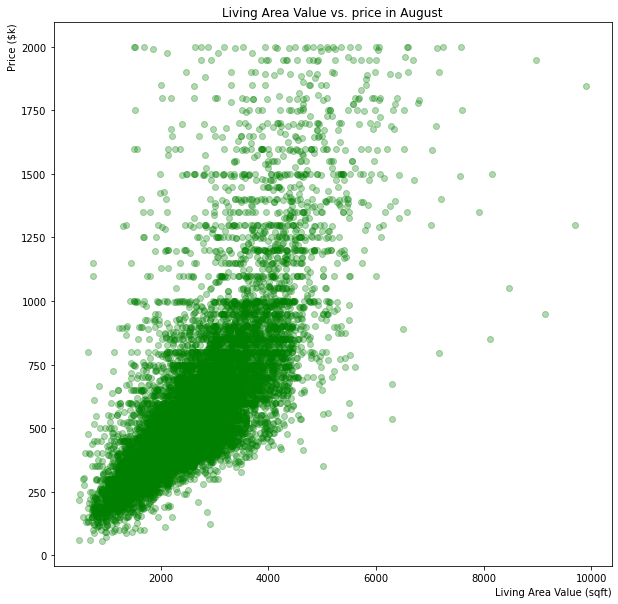

Correlation coefficient between 2 variables: 
0.7594


In [12]:
df_main = class_df.return_df_house_properties()
df_main = df_main.loc[(df_main['price'] <= 2000000) & (df_main['livingAreaValue'] <= 10000)]

plt.figure(figsize = (10, 10))
plt.scatter(df_main['livingAreaValue'], df_main['price']/1000, alpha = 0.3, color = 'green')
plt.xlabel('Living Area Value (sqft)', horizontalalignment = 'right', x = 1)
plt.ylabel('Price ($k)', horizontalalignment = 'right', y = 1)
plt.title('Living Area Value vs. price in August')
plt.show()

print('Correlation coefficient between 2 variables: ')
print(np.round(np.corrcoef(df_main['livingAreaValue'], df_main['price'])[0][1], 4)) 
##We want price from $0 to $2000000 since these houses are affordable and dominate the house market
##We want lot area from

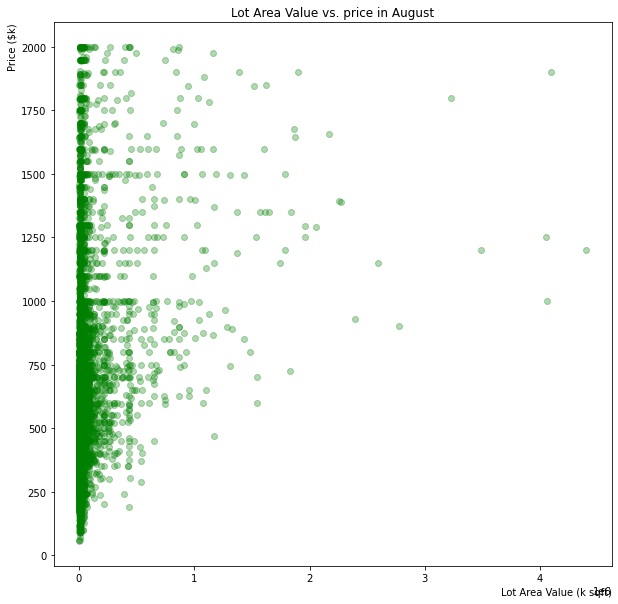

Correlation coefficient between 2 variables: 
0.2681


In [14]:
##lot area vs. price
plt.figure(figsize = (10, 10))
plt.scatter(df_main['lotArea'], df_main['price']/1000, alpha = 0.3, color = 'green')
plt.xlabel('Lot Area Value (k sqft)', horizontalalignment = 'right', x = 1)
plt.ylabel('Price ($k)', horizontalalignment = 'right', y = 1)
plt.title('Lot Area Value vs. price in August')
plt.show()

df_sun = df_main.loc[~(df_main['lotArea'].isnull())]
print('Correlation coefficient between 2 variables: ')
print(np.round(np.corrcoef(df_sun['lotArea'], df_sun['price'])[0][1], 4)) 

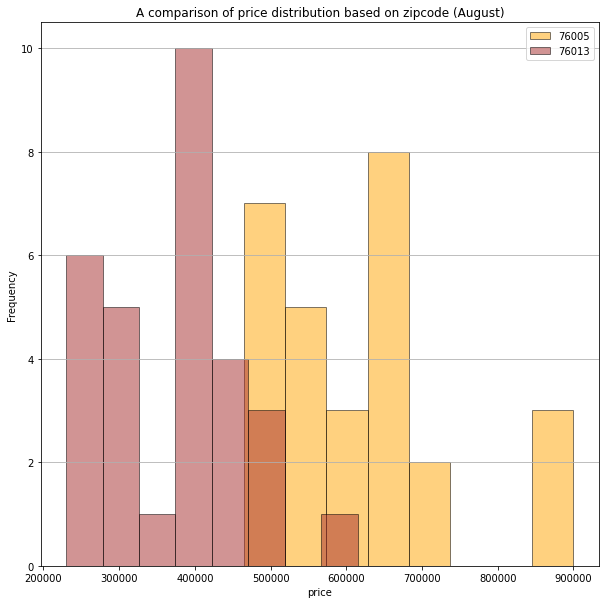

The mean and median of houses's prices in 76005 (August): 618637 | 587373
The mean and median of houses's prices in 76013 (August): 374713 | 387000


In [47]:
## Comparison of zipcode
df_zipcode = class_df.return_df_house_properties()
df_76005 = df_zipcode.loc[df_zipcode['zipcode'] == 76005]
df_76013 = df_zipcode.loc[df_zipcode['zipcode'] == 76013]

plt.figure(figsize = (10, 10))
plt.hist(df_76005['price'], bins = 8, edgecolor='black', color = 'orange', alpha = 0.5, label = '76005')
plt.hist(df_76013['price'], bins = 8, edgecolor='black', color = 'brown', alpha = 0.5, label = '76013')
plt.grid(True, axis = 'y')
plt.legend(loc = 'upper right')
plt.xlabel('price')
plt.ylabel('Frequency')
plt.title('A comparison of price distribution based on zipcode (August)')
plt.show()

##Statistic:
print("The mean and median of houses's prices in 76005 (August): {} | {}".format(round(np.mean(df_76005['price'])), round(np.median(df_76005['price']))))
print("The mean and median of houses's prices in 76013 (August): {} | {}".format(round(np.mean(df_76013['price'])), round(np.median(df_76013['price']))))

In [18]:
df_zipcode.zipcode.unique()

array([76426., 76071., 76082., 76431., 76234., 76073., 76023., 76078.,
       76225., 76052., 76259., 76020., 76270., 76487., 76247., 76458.,
       76258., 75068., 76201., 76208., 76266., 75056., 76205., 75067.,
       75057., 76209., 76227., 75287., 76249., 75065., 75022., 76207.,
       76177., 76210., 75028., 75007., 75077., 76226., 75010., 76262.,
       75078., 75034., 75036., 76115., 75510., 76179., 75009., 75033.,
       78681., 78753., 75024., 75063., 75093., 78745., 76092., 76272.,
       75407., 75173., 75409., 75442., 75424., 75166., 75074., 75069.,
       75002., 75098., 75454., 75075., 75189., 75071., 75023., 75070.,
       75048., 75035., 75025., 75072., 75252., 75495., 75089., 77662.,
       75094., 75013., 75082., 75080., 75248., 75044., 75491., 75087.,
       75452., 76085., 76066., 76086., 76088., 76087., 76049., 76108.,
       76008., 76462., 76067., 76131., 76126., 76486., 76035., 76485.,
       76135., 76110., 76104., 76114., 76119., 76112., 76133., 76164.,
      

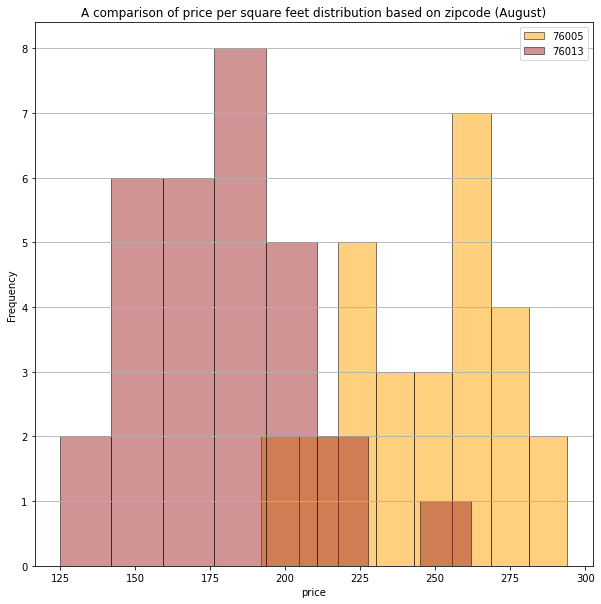

The mean and median of houses's prices in 76005 (August): 246 | 250
The mean and median of houses's prices in 76013 (August): 180 | 180


In [23]:
## Comparison of zipcode
df_zipcode = class_df.return_df_house_properties()
df_76115 = df_zipcode.loc[df_zipcode['zipcode'] == 76005]
df_76013 = df_zipcode.loc[df_zipcode['zipcode'] == 76013]

plt.figure(figsize = (10, 10))
plt.hist(df_76005['resoFacts.pricePerSquareFoot'], bins = 8, edgecolor='black', color = 'orange', alpha = 0.5, label = '76005')
plt.hist(df_76013['resoFacts.pricePerSquareFoot'], bins = 8, edgecolor='black', color = 'brown', alpha = 0.5, label = '76013')
plt.grid(True, axis = 'y')
plt.legend(loc = 'upper right')
plt.xlabel('price')
plt.ylabel('Frequency')
plt.title('A comparison of price per square feet distribution based on zipcode (August)')
plt.show()

##Statistic:
print("The mean and median of houses's prices in 76005 (August): {} | {}".format(round(np.mean(df_76005['resoFacts.pricePerSquareFoot'])), round(np.median(df_76005['resoFacts.pricePerSquareFoot']))))
print("The mean and median of houses's prices in 76013 (August): {} | {}".format(round(np.mean(df_76013['resoFacts.pricePerSquareFoot'])), round(np.median(df_76013['resoFacts.pricePerSquareFoot']))))

In [ ]:
##remodeling feature??
##Take all the numerical features and do 2 types of clustering standard K-means and spectral clusters.
##More zipcodes in one cluster, TSNE, MDS, LLE embedding in 2D, color coded, randomly picks 10.
##Zipcodes, swimming pools into classes.
##Or picks one zipcode that has a significant price distribution